In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
import sys
import pdb
from copy import deepcopy
from tqdm import tqdm
import astropy.units as u
import mpl_scatter_density

import seaborn as sns
plt.style.use('seaborn')

/var/folders/d7/mj7t5gvn7kxcpnv91gn5rxs5myk4z8/T/ipykernel_41640/2184438354.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Just importing my stuff

In [2]:
sys.path.append('/Users/anh5866/Desktop/Coding')
import PyXFocus.sources as sources
import PyXFocus.transformations as trans
import PyXFocus.surfaces as surfaces
import PyXFocus.analyses as analyses
import PyXFocus.conicsolve as conic

import OGRE.ogre_routines_alexplay as ogre

soxs : [WARNING  ] 2024-08-23 12:36:09,528 Setting 'soxs_data_dir' to /Users/anh5866/Library/Caches/soxs for this session. Please update your configuration if you want it somewhere else.


More importing stuff 

In [3]:
z0 = 3500. * u.mm  # Focal length.
num_shell = 12 #number of shells in optic

mirror_length = 300 * u.mm  # Axial length of primary / secondary mirror.
mirror_sep = 10 * u.mm  # Separation between primary and secondary mirrors.


shell_arr = np.array([187.181697, 195.044289, 203.186973, 211.689775, 220.552696, 229.775737, 239.398908, 249.422212, 
                  259.865654, 270.729235, 282.052968, 293.856858]) 

d_int_ter = np.array([187.181697, 195.044289, 203.186973, 211.689775, 220.552696, 229.775737, 239.398908, 249.422212, 
                  259.865654, 270.729235, 282.052968, 293.856858]) * u.mm

#two different arrays - one has astropy units "mm" and the other one doesn't 

r_int_ter= d_int_ter/2 #Radius at intersection node
#divide by two for the radius 

# at intersection node

Making a class that can store all the information concerning the mirrors. The information includes:
- Diameter at intersection node
- Radius at intersection node
- Z position of parabola front
- Z position of parabola back
- radius of front of assembly 
- radius back of primary mirror

In [4]:
class mirrors:
    def __init__(self, d_intersection):
        
        self.d_int = d_intersection * u.mm #Diameter at intersection node
        self.r_int = d_intersection/2 * u.mm #Radius at intersection node
        
        self.zp_back = z0 + mirror_sep/2  # Axial position of parabola front.
        self.zp_front = self.zp_back + mirror_length  # axial position of parabola back.
        
        self.rp_front = conic.primrad(self.zp_front, self.r_int, z0) #radial value using the z value for parabola 
        self.rp_back = conic.primrad(self.zp_back, self.r_int, z0) #back of primary mirror (~same as intersection node)
        #(at intersection node for JET-X)
        

Ray Parameters:
- opd : vector tracking the optical path traveled by each ray; only surfaces with an OPD flag in their definition will update this vector.
- x, y, z : ray positions in the Cartesian coordinate system [mm].
- l, m, n : ray direction cosines, indicating the direction in which each ray is moving; magnitude is unity.
- ux, uy, uz : the surface normal of the last surface to which the ray was traced; magnitude is unity.


Making a class that can store all the information concerning the mirrors. The information includes:
- positions and directions (x,y,z,l,m,n,ux,uy,uz)
- wavelength (of source)
- order to be used 
- index 
- weight (probability of being detected)

In [5]:
class OGRERays:
    def __init__(self, PyXFocusRays, wave, order):
        self.opd = PyXFocusRays[0]
        self.x = PyXFocusRays[1]
        self.y = PyXFocusRays[2]
        self.z = PyXFocusRays[3]
        self.vx = PyXFocusRays[4]
        self.vy = PyXFocusRays[5]
        self.vz = PyXFocusRays[6]
        self.nx = PyXFocusRays[7]
        self.ny = PyXFocusRays[8]
        self.nz = PyXFocusRays[9]
        self.wave = wave
        self.order = order
        self.index = np.arange(len(PyXFocusRays[0]))
        self.weight = np.ones(len(PyXFocusRays[0]))
        
    def set_prays(self,PyXFocusRays, ind = None):
        if ind is not None:
            self.opd[ind] = PyXFocusRays[0]
            self.x[ind] = PyXFocusRays[1]
            self.y[ind] = PyXFocusRays[2]
            self.z[ind] = PyXFocusRays[3]
            self.vx[ind] = PyXFocusRays[4]
            self.vy[ind] = PyXFocusRays[5]
            self.vz[ind] = PyXFocusRays[6]
            self.nx[ind] = PyXFocusRays[7]
            self.ny[ind] = PyXFocusRays[8]
            self.nz[ind] = PyXFocusRays[9]
        else:
            self.opd = PyXFocusRays[0]
            self.x = PyXFocusRays[1]
            self.y = PyXFocusRays[2]
            self.z = PyXFocusRays[3]
            self.vx = PyXFocusRays[4]
            self.vy = PyXFocusRays[5]
            self.vz = PyXFocusRays[6]
            self.nx = PyXFocusRays[7]
            self.ny = PyXFocusRays[8]
            self.nz = PyXFocusRays[9]
            
    def yield_prays(self, ind = None):
        if ind is not None:
            return [self.opd[ind],self.x[ind],self.y[ind],self.z[ind],self.vx[ind],self.vy[ind],self.vz[ind],self.nx[ind],self.ny[ind],self.nz[ind]]
        else:
            return [self.opd,self.x,self.y,self.z,self.vx,self.vy,self.vz,self.nx,self.ny,self.nz]
        
        #returns parameters 
        

    def yield_object_indices(self, ind):
        new_object = deepcopy(self)
        for key in self.__dict__.keys():
            new_object.__dict__[key] = self.__dict__[key][ind]
        return new_object

In [6]:
mirrors_list = [mirrors(shell) for shell in shell_arr]

mirrors_list[0].rp_back *2

<Quantity 187.24852075 mm>

In [7]:
# PANTER Parameters
L = (123000. + 12000) * u.mm  # Approximate
L -= 4000. * u.mm  # Accounts for focal length of optic in the finite conjugate 
#subtracting 4000

#L = 10e12 * u.mm
#if you want an infinite source, you put a really big number like this for L

#wave = 0.98903  # [nm] Mg-K wavelength.
wave = 0.83401 * u.nm # Al-K wavelength.

order = -6


print(L)

131000.0 mm


In [8]:
# Define full angular width of subannulus.
#dphi = 30 * u.deg
dphi = 360 * u.deg

In [9]:
# Define inner and outer subannulus .
z_in = z0 + mirror_sep/2
z_out = z_in + mirror_length

print(z_in)
print(z_out)


r_in = conic.primrad(z_in, mirrors_list[0].r_int, z0)
r_out = conic.primrad(z_out, mirrors_list[-1].r_int, z0) #-1 is the last value in array 

print(r_in*2) #back of innermost primary mirror
print(r_out*2) #front of outer primary mirror

3505.0 mm
3805.0 mm
187.2485207463779 mm
300.1870360974702 mm


In [10]:
# Define subannulus of rays.
rays = sources.subannulus(r_in.to('mm').value, r_out.to('mm').value,
                          dphi.to('rad').value, 100000)

In [11]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 11.60805232, 118.85480051,  75.90486991, ...,  52.39935727,
         -6.34515295, 108.52275845]),
 array([ 100.48055791,  -75.07532474,   62.52613317, ...,  -92.4451919 ,
        -145.3953203 ,  -74.98907543]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [12]:
OGRERays_list = OGRERays(rays, wave, order)

OGRERays_list.z

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
# Rotate so that dispersion direction is in the x-dimension.
trans.transform(rays, 0, 0, 0, 0, 0, -np.pi/2)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([-100.48055791,   75.07532474,  -62.52613317, ...,   92.4451919 ,
         145.3953203 ,   74.98907543]),
 array([ 11.60805232, 118.85480051,  75.90486991, ...,  52.39935727,
         -6.34515295, 108.52275845]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

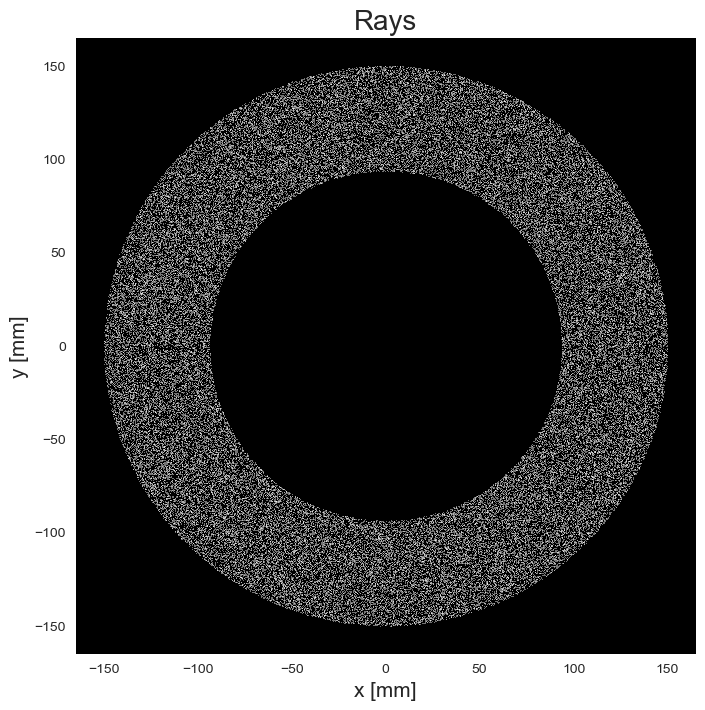

In [14]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

/Users/anh5866/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/anh5866/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


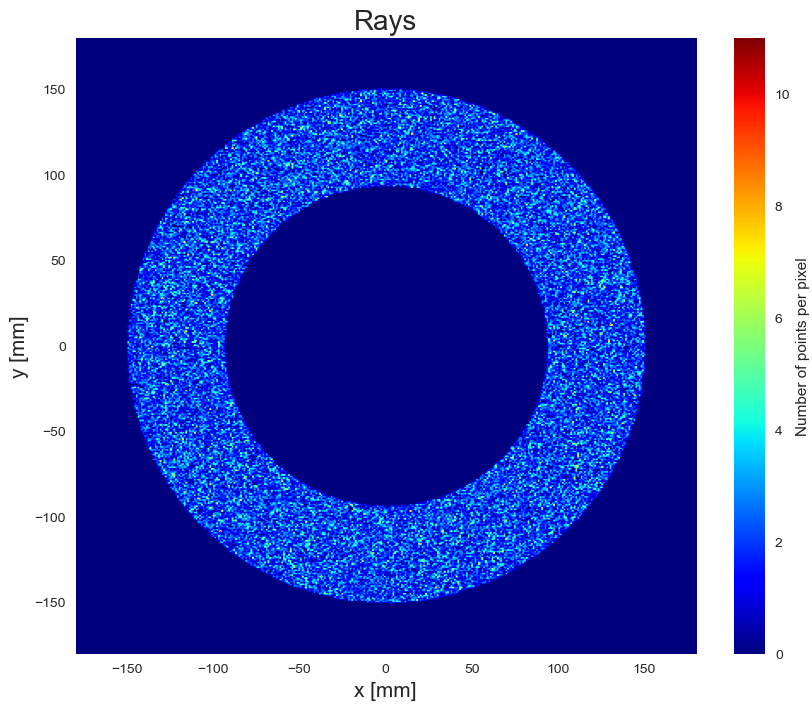

In [15]:
sns.set_style("ticks")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1, 1, 1, projection='scatter_density')

#color_map = plt.get_cmap('plasma')
color_map = plt.get_cmap('jet')

density = ax1.scatter_density(rays[1], rays[2], cmap = color_map)
ax1.set_ylim(-180,180)
ax1.set_xlim(-180,180)

ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)

ax1.set_title("Rays", fontsize=20)

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)

fig.colorbar(density, label='Number of points per pixel')

In [16]:
# Find centroid of rays and move rays down to center of beamline.
cen_optic = analyses.centroid(rays)
trans.transform(rays, 0, cen_optic[1], 0, 0, 0, 0)

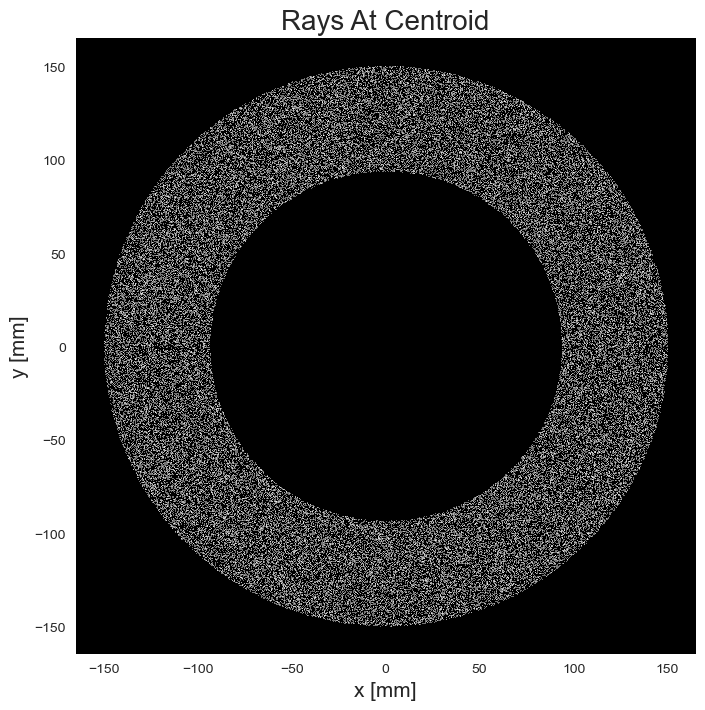

In [17]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays At Centroid", fontsize=20)
    #ax1.grid()

In [18]:
# Change ray direction cosines to emanate from source (48 m away). Long cell
# Change ray direction cosines to emanate from source (131 m away). PANTER
hyp = np.sqrt(L.to('mm').value**2 + rays[1]**2 + rays[2]**2)
l = rays[1]/hyp
m = rays[2]/hyp
n = -np.sqrt(1. - l**2 - m**2)
rays = [rays[0], rays[1], rays[2], rays[3],
        l, m, n, rays[7], rays[8], rays[9]]

OGRERays_list = OGRERays(rays, wave, order)

In [19]:
# Shift rays back up.
trans.transform(rays, 0, -cen_optic[1], 0, 0, 0, 0)

# move global orgin to JET-X focus
trans.transform(rays, 0, 0, -z0.to('mm').value, 0, 0, 0)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([-100.48055791,   75.07532474,  -62.52613317, ...,   92.4451919 ,
         145.3953203 ,   74.98907543]),
 array([ 11.60805232, 118.85480051,  75.90486991, ...,  52.39935727,
         -6.34515295, 108.52275845]),
 array([3500., 3500., 3500., ..., 3500., 3500., 3500.]),
 array([-0.00076703,  0.00057309, -0.0004773 , ...,  0.00070569,
         0.00110989,  0.00057244]),
 array([ 9.26089929e-05,  9.11285960e-04,  5.83424256e-04, ...,
         4.03992894e-04, -4.44383205e-05,  8.32415513e-04]),
 array([-0.9999997 , -0.99999942, -0.99999972, ..., -0.99999967,
        -0.99999938, -0.99999949]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

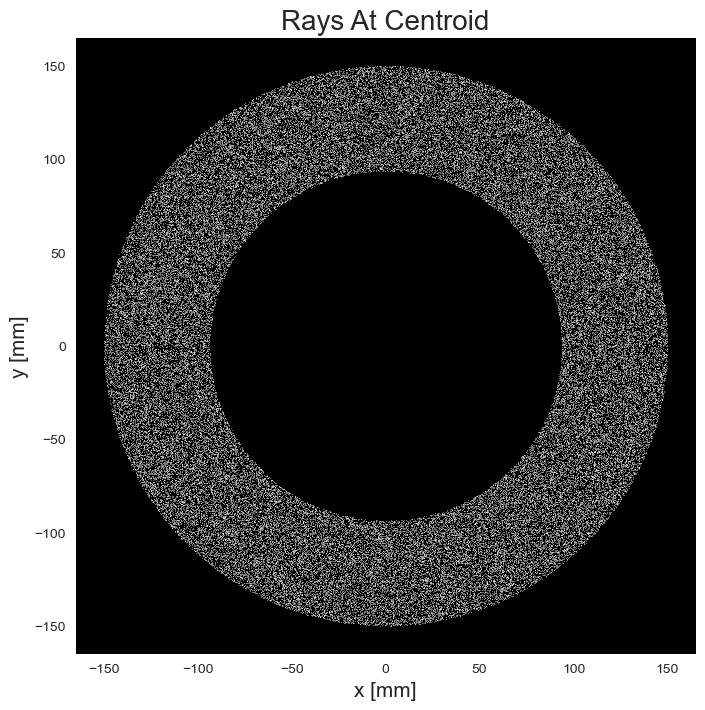

In [20]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays At Centroid", fontsize=20)
    #ax1.grid()

In [21]:
# Define blank PyXFocus ray object.
new_rays = sources.annulus(0,0,0) 

print(len(rays[1]))

100000


In [22]:
mirrors_list = [mirrors(shell) for shell in shell_arr]

In [23]:
def loc_rays(rays, rp_back, rp_front):
    
    # Find photons which will hit this mirror shell.
    r = np.sqrt(rays[1]**2 + rays[2]**2) #cartesian to polar transformation — "r" as radius for each of the rays
    # r = sqrt(x^2 + y^2)

    #this need to be edited. Another function perhaps ?
    ind = np.where((r > rp_back.to('mm').value) & (r < rp_front.to('mm').value))[0]
    #which rays fall within each shell (from each persspecive front radii to back radii)
    
    print(ind)
    
    
    # Create new ray object with only these rays.
    #ind_rays = [r[ind] for r in rays] #mask
    

    
    return ind

In [24]:
mirrors_list[0].rp_front *2

<Quantity 191.21521466 mm>

In [25]:
mirrors_list[0].rp_back *2

<Quantity 187.24852075 mm>

In [26]:
print(len(OGRERays_list.weight))

100000


In [27]:
result = np.zeros_like(rays[1]) #all start with weight of 0 (won't make it to detector)
for mirror in mirrors_list:
    vignette_init = loc_rays(rays, mirror.rp_back, mirror.rp_front) #which rays hit the primary mirror
    result[vignette_init] = 1 #assign weight to the rays that make it through 

OGRERays_list.weight = result #add to class list 
#might be good to add to the OGRE ray index which mirror the rays hit ; new object 


print(OGRERays_list.weight[22])
print(np.sum(OGRERays_list.weight)) #how many total have weight of 1

[   67   137   201 ... 99818 99880 99940]
[    2    14    33 ... 99868 99941 99959]
[    7    13    26 ... 99974 99988 99991]
[   15    19    20 ... 99942 99944 99997]
[    4    21    27 ... 99819 99923 99972]
[    8    24    85 ... 99912 99926 99980]
[    3    43    91 ... 99949 99952 99981]
[   38    56    61 ... 99938 99982 99987]
[   25    47    88 ... 99963 99990 99999]
[    6    10    41 ... 99956 99962 99975]
[   16    32    39 ... 99945 99970 99994]
[   23    69    93 ... 99968 99976 99985]
0.0
53816.0


In [28]:
soms = np.where(OGRERays_list.weight == 1) #where the rays are 1, that is, they make it through 

new_rays = OGRERays_list.yield_prays(soms) #using yield_prays function to make pray object 

Now I am plotting the rays that make it through, weighted 1

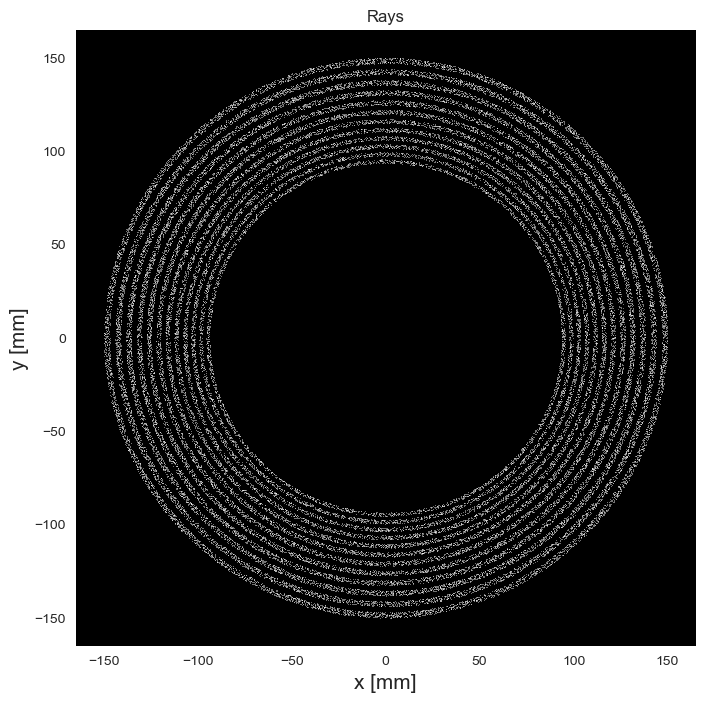

In [29]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')
    
    ax1.scatter(OGRERays_list.x[soms], OGRERays_list.y[soms], color="white", alpha=0.6, marker='.', s=0.5)
    #ax1.scatter(new_rays[1], new_rays[2], color="white", alpha=0.6, marker='.', s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

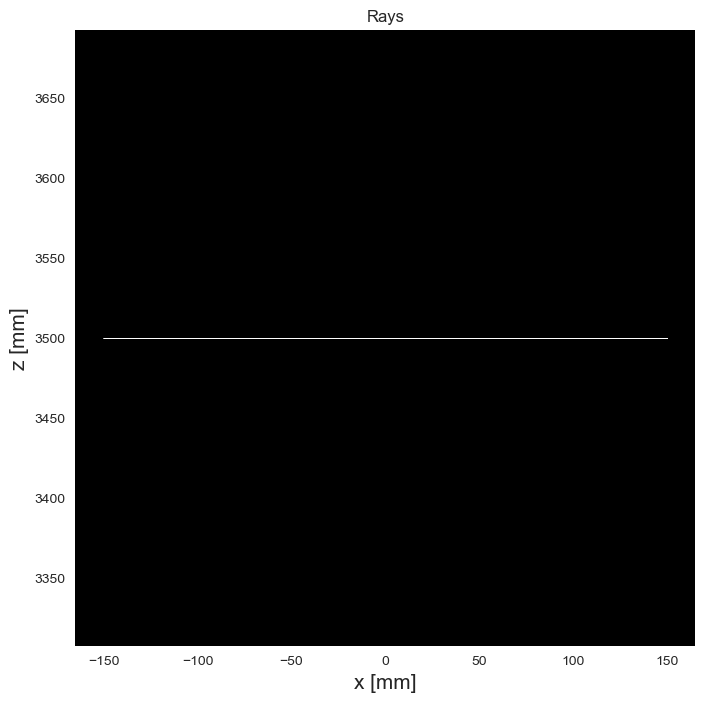

In [30]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('z [mm]', fontsize=15)
    
    ax1.set_facecolor('black')
    
    ax1.scatter(OGRERays_list.x[soms], OGRERays_list.z[soms], color="white", alpha=0.6, marker='.', s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

In [31]:
def loc_primary(rays, r_int):
    # Propagate these photons to primary mirror.
    surfaces.wolterprimary(rays, r_int.to('mm').value, z0.to('mm').value) 
    
    # Find which photons interact with this mirror.
    ind = np.where((rays[3] > (z0 + mirror_sep/2).to('mm').value) &
                   (rays[3] < (z0 + mirror_sep/2 + mirror_length).to('mm').value))[0]
    #will lose more if source is off-axis, or if there is a seperation between mirrors 

    # Keep only the photons which interact with the actual size
    # of the mirror
    
    print(ind)
    
    
    #ind_rays = [r[ind] for r in rays]
    
    return ind

In [32]:
print(len(new_rays[0]))

print(len(OGRERays_list.weight))

53816
100000


In [33]:
result_prim = np.zeros_like(new_rays[1]) #all start with weight of 0 (won't make it to detector)
#result_prim = np.zeros_like(rays[1]) #all start with weight of 0 (won't make it to detector)

for i in range(len(mirrors_list)):
    vignette_prim = loc_primary(new_rays, mirrors_list[i].r_int)
    result_prim[vignette_prim] = 1

print(len(result_prim))
where_one = np.where(result_prim == 1)
print(len(where_one[0]))

[   36    73   110 ... 53722 53754 53783]
[    0     8    20 ... 53748 53784 53794]
[    4     7    17 ... 53802 53810 53812]
[    9    11    12 ... 53785 53786 53814]
[    2    13    18 ... 53723 53772 53801]
[    5    15    47 ... 53769 53775 53805]
[    1    25    51 ... 53788 53790 53806]
[   21    31    32 ... 53782 53807 53809]
[   16    26    49 ... 53796 53811 53815]
[    3     6    24 ... 53793 53795 53803]
[   10    19    22 ... 53787 53800 53813]
[   14    38    52 ... 53799 53804 53808]
53816
53727


In [34]:
soms_one = soms[0] #changing shape of soms to 1

#should be same size
print(len(soms_one))
print(len(result_prim))

53816
53816


In [35]:
updated_ones_indices = soms_one[result_prim == 1] # applying a new mask, where result_prim is the new mask

OGRERays_list.weight[soms_one] = 0 # Set all current '1' entries in OGRERays_list.weight to '0'
OGRERays_list.weight[updated_ones_indices] = 1  # Set the remaining '1's according to the new mask

In [36]:
print(result_prim)
print(len(result_prim))
print(np.sum(result_prim))

[1. 1. 1. ... 1. 1. 1.]
53816
53727.0


In [37]:
print(result)
print(len(result))
print(np.sum(result))

[0. 0. 1. ... 1. 0. 1.]
100000
53727.0


In [38]:
#need to update dictionary too 

#before ad after?

In [39]:
soms_prim = np.where(OGRERays_list.weight == 1) #where the rays are 1, that is, they make it through 
new_rays_prim = OGRERays_list.yield_prays(soms_prim) #using yield_prays function to make pray object 
# new_rays_prim does not include weighted 0 rays 

In [40]:
trans.reflect(new_rays_prim)

In [52]:
new_rays_prim

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([-63.2280299 , -88.06601242, -50.83322532, ..., -23.16446439,
         93.31687859,  75.25214093]),
 array([  76.76283092,   82.34950607, -100.96632755, ...,  140.19611122,
          52.89838107,  108.90529909]),
 array([2029.4393284 , 2672.51489589, 2440.72214002, ..., 3346.79437626,
        2264.77127254, 3040.44532202]),
 array([-0.0004773 , -0.00066804, -0.00038493, ..., -0.00017662,
         0.00070569,  0.00057244]),
 array([ 0.00058342,  0.00062865, -0.00076059, ...,  0.00107294,
         0.00040399,  0.00083242]),
 array([-0.99999972, -0.99999958, -0.99999964, ..., -0.99999941,
        -0.99999967, -0.99999949]),
 array([ 0.63542058,  0.73003446,  0.44944965, ...,  0.16293742,
        -0.86947439, -0.56818657]),
 array([-0.77144081, -0.68264675,  0.89270905, ..., -0.98613082,
        -0.49287748, -0.82228263]),
 array([0.03346283, 0.032297  , 0.03264288, ..., 0.03158156, 0.03295571,
        0.03186356])]

In [50]:
OGRERays_list.weight

array([0., 0., 1., ..., 1., 0., 1.])

In [53]:
OGRERays_list.y

array([ 11.60805232, 118.85480051,  75.90486991, ...,  52.39935727,
        -6.34515295, 108.52275845])

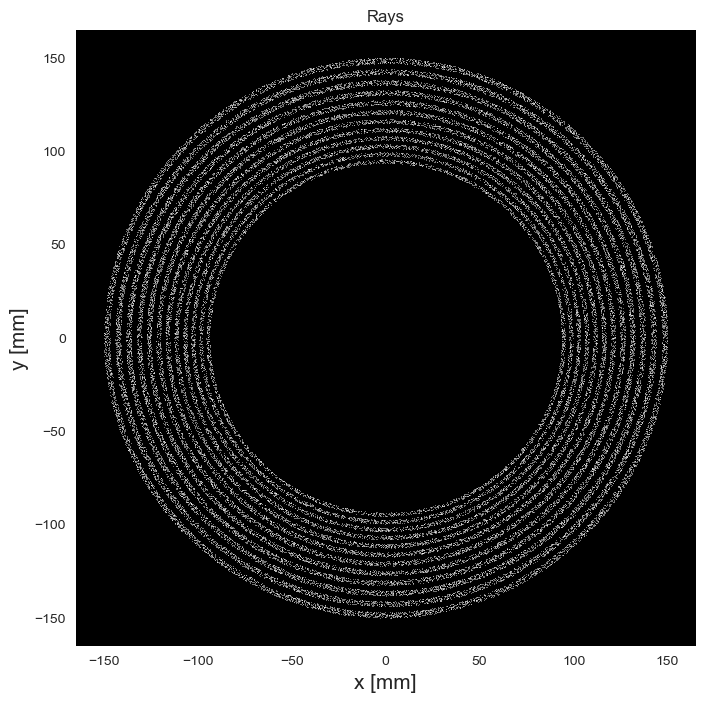

In [41]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')
    
    ax1.scatter(OGRERays_list.x[soms_prim], OGRERays_list.y[soms_prim], color="white", alpha=0.6, marker='.', s=0.5)
    #ax1.scatter(new_rays_prim[1], new_rays_prim[2], color="white", alpha=0.6, marker='.', s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

In [42]:
new_rays_prim[1]

array([-62.52613317, -87.5132194 , -50.42548032, ..., -23.137405  ,
        92.4451919 ,  74.98907543])

In [43]:
OGRERays_list.x

array([-100.48055791,   75.07532474,  -62.52613317, ...,   92.4451919 ,
        145.3953203 ,   74.98907543])

### Secondary 

In [44]:
def loc_secondary(rays, r_int):
    
    # Propagate photons to the secondary mirror.
    surfaces.woltersecondary(rays, r_int.to('mm').value, z0.to('mm').value)

    # Find which photons will interact with hyperboloid.
    ind = np.where((rays[3] < (z0 - mirror_sep/2).to('mm').value) &
                   (rays[3] > (z0 - mirror_sep/2 - mirror_length).to('mm').value))[0]
    
    return ind 

In [45]:
result_sec = np.zeros_like(new_rays_prim[1]) #all start with weight of 0 (won't make it to detector)

for i in range(len(mirrors_list)):
    vignette_sec = loc_secondary(new_rays_prim, mirrors_list[i].r_int)
    result_sec[vignette_sec] = 1

print(len(result_sec))
where_one_sec = np.where(result_sec == 1)
print(len(where_one_sec[0]))

53727
47114


In [46]:
result_sec

array([1., 1., 1., ..., 1., 1., 1.])

In [47]:
soms_sec = np.where(OGRERays_list.weight == 1) #where the rays are 1, that is, they make it through 
soms_sec = soms[0] #changing shape of soms to 1

#should be same size
print(len(soms_sec))
print(len(result_sec))

53816
53727
